<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Neural Signals and Signal Processing (NX-421)</h2>
<hr style="clear:both"></hr>


Welcome to the laboratory computers for the course "Neural signals and signal processing". Today, you will see how to preprocess fMRI data as well as play around with diffusion weighted imaging to compute a simple tractography.

In [2]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

16:33:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:33:32: Debug: Adding duplicate animation handler for '1' type
16:33:32: Debug: Adding duplicate animation handler for '2' type
16:33:34: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:33:34: Debug: Adding duplicate animation handler for '1' type
16:33:34: Debug: Adding duplicate animation handler for '2' type


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 69.4 MB/s eta 0:00:00:00:0100:01


In [3]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:613): Gtk-CRITICAL **: 16:33:47.608: gtk_window_resize: assertion 'height > 0' failed


<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Careful ! 💡</b></p>
<p style='text-indent: 10px;'>
    Some of the fMRI preprocessing you will see below leverage the anatomical MRI being preprocessed, which you have done last week. In case of doubt, go back to the previous week to see what you might need to re-do.</p>
</span>
</div>

# 1. fMRI preprocessing

You are now familiar with the few steps of preprocessing revolving around the T1 anatomical file. The main preprocessing starts now, with the functional data. 

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b>💡 Do not forget QC! 💡</b></p>
<p style='text-indent: 10px;'>
    As always, in all your steps visualize the effect of what you're doing. This is the easiest way to check that what you're doing is actually having an effect and better yet: a <b>correct</b> effect!</p>
</span>
</div>

Note that one assumption with fMRI preprocessing is that you've already conducted the anatomical preprocessing. In particular, the two main steps you will need today (repeat it from lab 2) before launching the lab:
- T1 skull-stripping (use BET)
- T1 segmentation (use FAST)
Do it on sub-001, dataset with ID ds004226.


## 1.0 Problematic volumes removal

A problem can arise in fMRI. To showcase this, please execute the cell below (we'll show you something from another dataset just to drive our point home).

In [5]:
import subprocess
dataset_demo = 'ds000114'
subject_demo = '01'

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)

# Download one subject's data from each dataset
bids_root_demo = op.join(os.path.abspath(""),sample_path, dataset_demo)
preproc_root_demo = op.join(bids_root_demo, 'derivatives')

subprocess.run(["openneuro-py", "download", "--dataset", dataset_demo, "--target-dir", bids_root_demo, "--include", 'sub-{}'.format(subject_demo)], check=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000114 …


📁 Traversing directories for ds000114 : 30 entities [00:04,  6.09 entities/s]


📥 Retrieving up to 19 files (5 concurrent downloads). 


sub-01_ses-retest_T1w.nii.gz:   0%|          | 0.00/8.11M [00:00<?, ?B/s]
sub-01_ses-retest_task-fingerfootlips_bold.nii.gz:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

sub-01_ses-retest_T1w.nii.gz:   1%|          | 82.5k/8.11M [00:00<00:18, 462kB/s]


sub-01_ses-retest_task-linebisection_events.tsv:   0%|          | 0.00/4.82k [00:00<?, ?B/s]


                                                                                            


sub-01_ses-retest_T1w.nii.gz:   3%|▎         | 253k/8.11M [00:00<00:08, 1.03MB/s].3M [00:00<?, ?B/s]
sub-01_ses-retest_task-fingerfootlips_bold.nii.gz:   0%|          | 74.5k/22.7M [00:00<00:56, 420kB/s]

sub-01_ses-retest_dwi.nii.gz:   0%|          | 83.6k/95.3M [00:00<03:32, 469kB/s]


sub-01_ses-retest_T1w.nii.gz:   6%|▌         | 473k/8.11M [00:00<00:05, 1.49MB/s]1.3M [00:00<01:09, 321kB/s]
sub-01_ses-retest_task-fingerfootlips_bold.nii.gz:   1%|          | 279k/22.7M [00:00<00:20, 1.16MB/s]

sub-01_ses-retest_dwi.nii.gz:   0%|          | 255k/95

✅ Finished downloading ds000114.
 
🧠 Please enjoy your brains.
 


CompletedProcess(args=['openneuro-py', 'download', '--dataset', 'ds000114', '--target-dir', '/home/jovyan/Data/dataset/ds000114', '--include', 'sub-01'], returncode=0)

We've downloaded one functional volume from another dataset, because the phenomenon is really visible in this dataset. 
Before going any further in this tutorial, let's open up our data and have a look at them. <u>You should always look at your data before conducting any sort of analysis</u>. See if you find anything at all that looks strange. You should look for

- [ ] Volumes moving in space (ie: head motion)
- [ ] Non homogeneities that do not seem to be coming from brain activity
- [ ] Changes in *overall* contrast

To open the volume of interest in FSL eyes, simply run:

In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root_demo, 'sub-01', 'ses-test', 'func', 'sub-01_ses-test_task-fingerfootlips_bold.nii.gz'))


(ipykernel_launcher.py:613): Gdk-WARNING **: 16:39:07.218: gdkdrawable-x11.c:952 drawable is not a pixmap or window


Did you find anything?
If so, what volumes would you remove, approximately?

### 1.0.1 Field stabilization

The scanner's field takes some time to settle. You probably noticed that the initial volume had a high contrast that quickly decayed to some baseline? It is precisely caused by the scanner's field settling.

These scans are called *non-stationary volumes*, because they are acquired while the B0 field is not yet not stable.

There's little to be done in this regard; we can only throw away the volumes that are contaminated in this specific case, to ensure this change in global signal does not drive our analysis.

If we're being really formal, a higher overall contrast can be detected by looking at the mean voxel value in each volume, like so:

Text(0, 0.5, 'Mean voxel intensity')

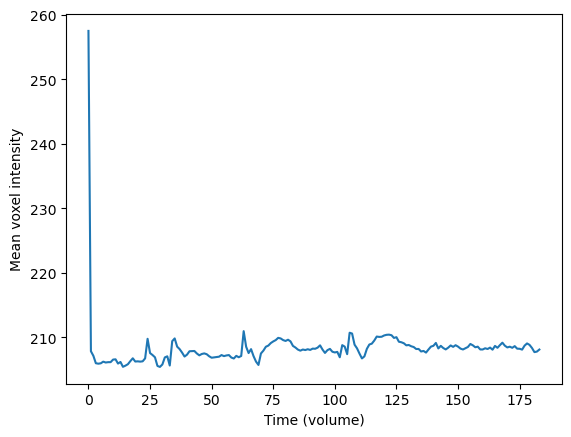

In [7]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root_demo, 'sub-01', 'ses-test', 'func', 'sub-01_ses-test_task-fingerfootlips_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

Clearly, while we could throw away only the first volume and the second one for good measure, we'll **choose** to discard the first 10 volumes, to be absolutely sure the scanner is settled.

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> Modern techs to the rescue</b></p>
<p style='text-indent: 10px;'>
    Most scanners nowadays actually acquire few scans to help the B0 field settle. These are called dummy scans; the scanner acquires them but throws them away, meaning that you end up with a result that is settled. You should pay attention however if you ever analyze older datasets, as they will not benefit from these new techs obviously!</p>
</span>
</div>

In [10]:
file_to_trim = glob.glob(op.join(bids_root_demo, 'sub-01', 'ses-test', 'func', 'sub-01_ses-test_task-fingerfootlips_bold.nii.gz'))[0]
mkdir_no_exist(preproc_root_demo)
mkdir_no_exist(op.join(preproc_root_demo, 'sub-01'))
mkdir_no_exist(op.join(preproc_root_demo, 'sub-01', 'ses-test'))
mkdir_no_exist(op.join(preproc_root_demo, 'sub-01', 'ses-test','func'))
output_target = op.join(preproc_root_demo, 'sub-01', 'ses-test', 'func', 'sub-01_ses-test_task-fingerfootlips_bold_settled.nii.gz')

############################
# Solution
# We will start from the 10th volume.
# Because we start at 0, we begin at the 11th volume, excluding 10 volumes: we should start at number 10.
# There are 184 volumes. We remove 11 volumes, so we're left with 174 volumes.
###########################

# For this, knowing that there are originally 184 volumes and that you want to throw away the first 10, please fill in
# the following variables
start_vol = 10 # Where should we start? (First volume is 0, not 1 !)
number_of_volumes = 174 # How many volumes should we keep?

fslroi(file_to_trim, output_target, str(start_vol), str(number_of_volumes))

{}

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b>🏠 Take-home message 🏠</b></p>
<p>Always look at your data!</p>
</span>
</div>


Let's go back to our original dataset now. :)

## 1.2 Motion correction

Motion correction here specifically means trying to make it such that a given voxel describes the same brain position in all volumes.

To illustrate why it might be a good idea, let's have a look at the functional data of our participant. Watch the movie. Do you notice anything strange?

<center><img src="imgs/motion.gif"/>
    <p style="text-align:center;"><i>You might want to pay attention to the axial view (right)</i></p></center>


The volumes tend to move a bit around, don't they?
<an example moment of motion>
    
This is a problem. Indeed, when we talk of a given voxel, our hope for analysis is that it represents a specific coordinate of anatomy. Imagine if you were trying to find your way with Google Maps, but every now and then the houses would suddenly all move by one kilometer! Would not be so easy to get to the right address, would it? Well, here it's the same. We want that a given (X, Y, Z) position describes always the same portion of the brain, otherwise our analysis will simply not work.

But because of motion, this is not the case.
    
This is one of the core issues of fMRI: the participant simply moved, ever so slightly, during the acquisition. As a consequence, well, we have a recording of a moving participant. This is not a rare phenomenon: imagine having to keep your head perfectly still for several minutes and you'll quickly understand that it is **hard**!
    
Still, we would like to do something about it. This is where motion correction steps in. There are two sides to motion correction. The first, which we'll cover here, attempts to put all volumes back in alignment, so that a given position is indeed consistently describing the same anatomical part for all volumes. The second, which you'll see next week, attempts to correct for the consequences of motion on the magnetic field.
<br><br>
Do you remember Ducky? Well, imagine now that our dear duck has a rare shaking disease.
    <br><img src="imgs/ducky/shakyducky.png" style="width:auto;height:500px;"/>
<br>If we take several consecutive pictures of Ducky, it won't be as aligned as it should be
    <br><img src="imgs/ducky/duckies_before_reg.png" style="width:900px;height:auto;"/>
<br>To correct this, I can apply the idea we used in normalization. Let's pick one Ducky image as reference. Then, all other images of Ducky will be registered to this Ducky
    <br><img src="imgs/ducky/duckies_reg.png" style="width:900px;height:auto;"/>
    <br><img src="imgs/ducky/duckies_after_reg.png" style="width:900px;height:auto;"/>
<br>Now, what if I want to remember how much Ducky had moved ? Well, I can remember the parameters of the transformation I had to apply to align the volumes. This fully encapsulates the motion information.

This is precisely what motion correction sets out to achieve. For this, we need first to define a reference, if possible in fMRI space and that would not require too much transformations. Which option(s) seem reasonable to you?:

In [11]:
interactive_MCQ(3,1)

HTML(value='<h3>Which type volume should we use to perform fMRI motion-correction?</h3>')

It turns out the first two options are usually equivalent. Because it saves us one pass of average computation, we will choose the first option: picking a volume and using it as reference! Which one do you think would be good?

In [12]:
interactive_MCQ(3,2)

HTML(value='<h3>Which volume im the fMRI timeserie CAN we use to perform motion-correction?</h3>')

Now, let us perform this step, on our **first** dataset (the one without fieldmaps). In FSL, we use <a href="https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT">MCFLIRT</a> to perform this correction.
<br>
    
<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Pay attention ! 💡</b></p>
<p style='text-indent: 10px;'>
    By default, MCFLIRT selects the middle volume of the EPI serie as reference to which other volumes are realigned.</p>
</span>
</div>

In [15]:
from fsl.wrappers import mcflirt

dataset_id = 'ds004226'
subject = '001' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, "--target-dir", bids_root, "--include", 'sub-{}'.format(subject)], check=True)

#mkdir_no_exist(bids_root)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)
mkdir_no_exist(os.path.join(preproc_root, 'sub-001'))
mkdir_no_exist(os.path.join(preproc_root, 'sub-001', 'func'))

path_original_data = os.path.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold')
path_moco_data = os.path.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004226 …


📁 Traversing directories for ds004226 : 70 entities [00:07,  9.71 entities/s]


📥 Retrieving up to 40 files (5 concurrent downloads). 


✅ Finished downloading ds004226.
 
🧠 Please enjoy your brains.
 


Processed data will be saved as /home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/func/sub-001_task-sitrep_run-01_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [182] to 8 mm pixels
Registering volumes ... [183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][

refnum = 182
Original_refvol = -1


Registering volumes ... [183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][181][180][179][178][177][176][175][174][173][172][171][170][169][168][

{}

Okay! So, what do we have now?

In [16]:
print_dir_tree(bids_root, max_depth=5)

|ds004226/
|--- CHANGES
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-001/
|------------ func/
|--------------- sub-001_task-sitrep_run-01_bold_moco.nii.gz
|--------------- sub-001_task-sitrep_run-01_bold_moco.par
|--------------- sub-001_task-sitrep_run-01_bold_moco.mat/
|--- sub-001/
|------ sub-001_scans.tsv
|------ anat/
|--------- sub-001_T1w.json
|--------- sub-001_T1w.nii.gz
|------ fmap/
|--------- sub-001_acq-task_dir-AP_epi.json
|--------- sub-001_acq-task_dir-AP_epi.nii.gz
|--------- sub-001_acq-task_dir-PA_epi.json
|--------- sub-001_acq-task_dir-PA_epi.nii.gz
|------ func/
|--------- sub-001_task-sitrep_run-01_bold.json
|--------- sub-001_task-sitrep_run-01_bold.nii.gz
|--------- sub-001_task-sitrep_run-01_events.tsv
|--------- sub-001_task-sitrep_run-02_bold.json
|--------- sub-001_task-sitrep_run-02_bold.nii.gz
|--------- sub-001_task-sitrep_run-02_events.tsv
|--------- sub-001_task-sitrep_run-03_bold.json

In the functional folder, notice that we have two new files:
```
sub-001_task-sitrep_run-01_bold_moco.nii.gz
sub-001_task-sitrep_run-01_bold_moco.par

```

The first one is the corrected EPI time serie, with volumes realigned. The second is a file describing the motion parameters that were used to move each volume. It will be useful very shortly to determine which volume moved by a lot.
Notice as well a new directory!
```
sub-001_task-sitrep_run-01_bold_moco.mat/
```
This directory is full of .MAT files. These are the transformation matrices used for every volume to realign them.

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Pay attention ! 💡</b></p>
<p style='text-indent: 10px;'>
    The motion parameters and the transformation matrices are related, but they are not exactly the same thing. While you can recover one from the other, it is not trivial. Applying the transformation matrix to a volume will put it 'in alignment' as you've done with FLIRT. However the motion parameters cannot be applied directly. Loosely, the motion parameters describe how you would move if you first applied a rotation along x, then along y, then along y, followed by transition along x, then transition along y, then transition along z. This ordering of transformations is **not** really what happens with the transformation matrices. It is a convention adopted by FSL to make it easier to decouple transformations and rotations in the motion parameter analysis; it is therefore a <b>convenience</b>.
    <u>Do not confuse transformation matrices and motion parameters</u>!</p>
</span>
</div>

Before going <u>any further</u>, go and have a look at the corrected timeseries.

In [17]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

Did mcflirt help correct motion? Are you convinced it did somewhat a proper job?
<br>
It's actually not too easy to tell right? Well, let's see if we can figure something out to ease our quality control!

#### 1.2.1 Motion parameters and degrees of freedom

We told you earlier that motion parameters can be used to estimate the motion along every axis.

In our invocation of mcflirt, notice the following:
```python
mcflirt(..., dof=6)
```
dof stands for <i><b>d</b>egrees <b>o</b>f <b>f</b>reedom</i>, it really means what kind of transformation we wish to apply. In a 3D transformation, we have 3 axis:<br>
<img src="imgs/3d_axis.png"/><br>
Along each axis, we can apply one transformation. Because we apply here only **affine** transformations, we can choose any transformation from:
- Translation along the axis
- Rotation along the axis
- Shear along the axis
- Scale along the axis

Together, you can see this gives in total **12** DOF.
We've chosen 6 DOFs, which is the standard choice: we want only to translate and rotate around the volumes, since they've been displaced by motion.

#### 1.2.2 Looking at the resulting correction parameters
Recall the motion parameters are stored in the .par file produced by MCFLIRT. Notice that since each volume moved differently, we have one transformation per volume, thus one set of motion parameters per volume as well. We provide you with a way to load these parameters:

In [18]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002539,-0.001657,0.000255,-0.059974,-0.102605,0.060640
1,-0.002459,-0.001657,-0.000015,-0.088470,-0.074804,0.059579
2,-0.000779,-0.001937,-0.000309,-0.088446,-0.142114,0.084735
3,-0.002650,-0.001788,-0.000407,-0.080511,-0.062457,0.088597
4,-0.001517,-0.001178,-0.000218,-0.087542,-0.154168,0.061600
...,...,...,...,...,...,...
359,0.007272,0.001156,0.000043,0.019384,0.049231,-0.227808
360,0.006955,0.001156,0.000043,0.004657,0.110900,-0.255578
361,0.008153,0.001373,0.000043,0.024424,-0.049469,-0.259512
362,0.007409,0.001269,0.000043,0.022275,0.140976,-0.228057


Based on **translation on X alone**, can you find perhaps a volume which exceeds with respect to the **preceding volume** a 0.2 mm displacement?

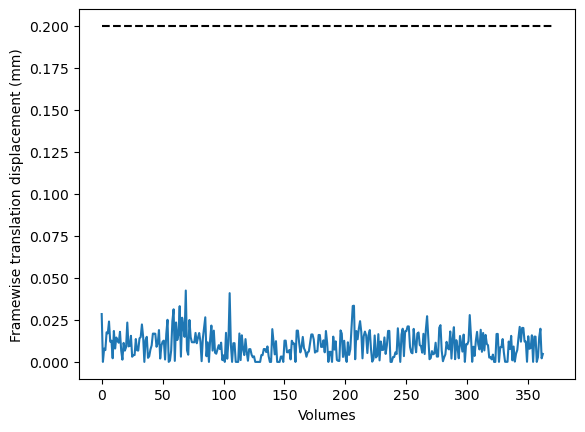

In [20]:
# write your code here to inspect quickly the translation on X :)
#%matplotlib inline

# Getting the translation is easy
trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

Some metrics have been created, to compute the displacement of a frame compared to the preceding frame: this is the frame-wise displacement. <br>(see <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3254728/">Power, Jonathan D., et al. "Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion." Neuroimage 59.3 (2012): 2142-2154.</a> for more details).<br>
We can use this one to extract an aggregate measure of motion for all volumes. 

In [21]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [22]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

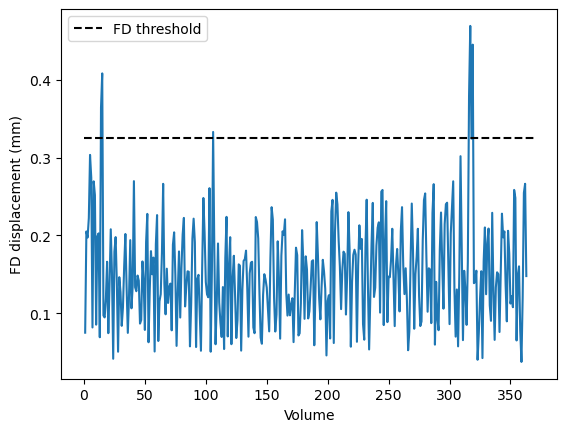

In [23]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

Okay great, but what if we want to know which volumes are actually above threshold? Simply run the cell below!

In [24]:
np.where(fd > threshold)[0] + 1

array([ 14,  15, 106, 316, 317, 319])

So, you now know which volumes might present motion that is worth checking. Go back to FSLeyes and contrast the uncorrected volumes with the corrected ones. Can you see what sort of motion was problematic and was eliminated?

## 1.3 Motion-correction: conclusions

Motion correction should always be conducted. As you've seen, it is extremely easy to do and has many benefits. However it is not infaillible. High motion tends to cause non linear effects in the signal that simple motion correction above cannot correct since it has no awareness of the magnetic field. <br>
<br> Motion parameters can, in this case, come to our rescue. As they represent the effect of motion, including them in our modeling to try and correct the signal can help. One could for example include this information in a General Linear Model to regress out the signal of these volumes (censoring) from overall timeseries. ➡️ More on this next week!

## 1.4 Where are we?

So, let's see what we have done so far:

<table>
    <tr><th style='text-align:justify;'>Data type</th><th style='text-align:justify;'>Step name </th><th style='text-align:justify;'>Details of the step</th><th style='text-align:justify;'>FSL tool </th></tr>
    <tr><th>Anatomical</th><td></td><td></td></tr>
    <tr><td></td><td style='text-align:justify;'>Skull stripping</td><td style='text-align:justify;'>Removing skull and surrounding tissues to keep only the brain</td><td style='text-align:justify;'>BET</td></tr>
    <tr><td></td><td style='text-align:justify;'>Segmentation</td><td style='text-align:justify;'>Segmenting brain tissues based on their contrasts</td><td style='text-align:justify;'>FAST</td></tr>
    <tr><td></td><td style='text-align:justify;'>Normalization</td><td style='text-align:justify;'>Mapping participant's brain to a reference brain, making its orientation and scale match so that comparison across participants become feasible.</td><td style='text-align:justify;'>FLIRT</td></tr>
    <tr><th>Functional</th><th></th><th></th></tr>
    <tr><td></td><td style='text-align:left;'>First few volumes removal</td><td style='text-align:justify;'>Removing volumes for which the B0 field is still not stable and that could contaminate all our data if left unchecked.</td><td style='text-align:justify;'>fslroi</td></tr>
    <tr><td></td><td style='text-align:left;'>Motion correction</td><td style='text-align:justify;'>Realignment of fMRI volumes to a common reference - typically one volume or the average of the volumes - to correct for inter-volume motion. The extracted motion parameters can be used for subsequent analysis (see GLM in two weeks!)</td><td style='text-align:justify;'>MCFLIRT (which is one suboption of FLIRT in fact)</td></tr>
</table>

You will see some additional steps next week (slice-timing and field unwarping to be specific).

## 1.5 Coregistration of functional to anatomical

You have seen coregistration last week, when you were trying to align the T1 to MNI152, both manually and algorithmically. In the specific case of putting a T1 anatomical in a template space (such as MNI), we call it <b>normalization</b>, because we...Normalize it !

You've also seen above with motion-correction coregistration of EPI volumes (functional data) to each other to correct motion.

But what if you wanted to put the functional data overlayed on the anatomy, to know more precisely which parts of the brain are activated?

You will see the last important ingredient to do this: coregistration between functional and anatomical.

In this specific case, it is a registration between images of different modalities. We want to register fMRI (EPI) to an anatomical image (T1). There are several reasons for this. The first that comes to mind is that if you overlay your fMRI on the anatomy, you can of course reason much more easily on where you are in the brain, what activations you might be looking at and so forth. Imagine a participant has a brain lesion visible on the anatomy and you want to see how this reflects on the fMRI. Being able to put the two together would make it much easier, would it not?

This is the first reason behind coregistration.

The second is because of normalization, again. Assume you want to compare all fMRI data of participants. Clearly, putting all of them into a common reference frame is a bit trickier, because of how noisy and low-resolution the data is, right? But you know how to map the anatomical to this common space with excellent accuracy, and you've saved this transformation earlier.
If you could figure out how to go from the fMRI space to anatomical, clearly the problem would be solved! You'd only have then to apply the transformation from anatomical to common space and be done with it.


Computing the fMRI space to anatomical transformation is precisely the goal of coregistration.
<br><br>
To do this step, we will use a wonderful command: <a href="https://web.mit.edu/fsl_v5.0.10/fsl/doc/wiki/FLIRT(2f)UserGuide.html#epi_reg">epi_reg</a> ! As the name states, it is a command to register an EPI. Hard to make it clearer huh? 

### 1.5.1 Using epi_reg to do the EPI registration

Notice that we want to compute the transformation to use for coregistration.

In [26]:
interactive_MCQ(3,3)

HTML(value='<h3>Now, we have an EPI, here of 364 volumes, each supposedly aligned by motion-correction. How ma…

RadioButtons(description='Choose:', layout=Layout(width='100%'), options=('364 times, once for each volume', '…

Output()

Your task is simple. You should:
- Fill in the name of the EPI target. It should be the **motion-corrected** EPI that you corrected using MCFLIRT. If you want to use a single volume, set the use_first_vol variable to True!
- Fill in the path to the whole head T1 image (**before** skull stripping was conducted!)
- Fill in the path to the skull-stripped T1 image (**after** skull stripping was conducted!)

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Pay attention ! 💡</b></p>
<p style='text-indent: 10px;'>
    Make sure that the whole head T1 and the skull-stripped T1 have the same orientation.
For example, if you ran fsl_anat to extract the brain (which is fine), FSL will change in the headers the orientation of the T1 before skull-stripping. As a consequence, the brain-extracted T1 no longer has the same orientation as the original T1. If you display them on top of each other, they are perfectly matched, but not from the perspective of the <b>headers</b>, which can play nasty tricks on you when performing coregistration.</p>
</span>
</div>

First, we'll show you the documentation of epi_reg:

In [30]:
subprocess.run(['epi_reg'])


Usage: epi_reg [options] --epi=<EPI image> --t1=<wholehead T1 image> --t1brain=<brain extracted T1 image> --out=<output name>
 
Optional arguments
  --fmap=<image>         : fieldmap image (in rad/s)
  --fmapmag=<image>      : fieldmap magnitude image - wholehead extracted
  --fmapmagbrain=<image> : fieldmap magnitude image - brain extracted
  --gdc=<image>          : Gradient-distortion corection warpfield
  --wmseg=<image>        : white matter segmentation of T1 image
  --echospacing=<val>    : Effective EPI echo spacing (sometimes called dwell time) - in seconds
  --pedir=<dir>          : phase encoding direction, dir = x/y/z/-x/-y/-z
  --weight=<image>       : weighting image (in T1 space)
  --nofmapreg            : do not perform registration of fmap to T1 (use if fmap already registered) 
  --noclean              : do not clean up intermediate files
  -v                     : verbose output
  -h                     : display this help message
 
e.g.:  epi_reg --epi=example_func

CompletedProcess(args=['epi_reg'], returncode=1)

epi_reg has one peculiarity. If you launch it on a 4D volume, it will truncate your result to the first volume, because it expects a *single* EPI volume. We should thus first extract a single volume from our EPI, and then call epi_reg on it. We do that for you below.

If you want to run with 4D volume to see the result and the warning, set use_single_vol to False

In [35]:
from fsl.wrappers import epi_reg

#################
# Solution
# We use the motion corrected EPI 
##################
# We use the motion corrected EPI
epi_target = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_moco')
whole_t1 = op.join(bids_root, 'sub-001', 'anat', 'sub-001_T1w')
skull_stripped_t1 = op.join(preproc_root, 'sub-001', 'anat', 'sub-001_T1w')
output_path = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_moco_vol_middle')

use_single_vol = True

if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    fslroi(epi_target, ref_vol_name, str(182), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])


Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.470641 0.999829 0.000219 0.018485 0.000000 -0.000654 0.999723 0.023542 0.000000 -0.018475 -0.023550 0.999552 0.000000 2.445408 5.671622 -1.623714 1.000000 


Notice how FAST is ran?
This is because the specific coregistration cost (boundary-based registration, BBR) uses the anatomical white-matter tissues from FAST. If no such tissue is provided to the function, it re-runs FAST to obtain it and use it. If you've already done anatomical segmentation, clearly there's no need to redo it right?
In particular, imagine if you had to yourself correct the white matter with the help of an expert because somehow FSL did a poor job on your data. Clearly you'd like to have this one used instead of the result from FAST, right?

Well- you can! We just need a new option in the epi_reg command:
```python
epi_reg(...,wmseg=path_to_your_white_matter_segmentation)
```
Remember from last week, which T1 file corresponds to the white matter, between pve_0, pve_1 and pve_2 ? Put it as your white matter segmentation. (Note: of course, you will need to re-do your T1 segmentation before you can feed it here - a good moment to remember the previous week and revisit FAST and BET ;) )

In [41]:
###############
# Solution
# White matter corresponds to pve_2.
##############

white_matter_segmentation = op.join(preproc_root, 'sub-001', 'anat', 'sub-001_T1w_fast_pve_2.nii.gz') # We provide the white matter segmentation

subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.466895 0.999861 0.000052 0.016673 0.000000 -0.000459 0.999700 0.024465 0.000000 -0.016667 -0.024470 0.999562 0.000000 2.172891 5.843331 -1.574347 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/func/sub-001_task-sitrep_run-01_bold_moco_vol_middle', '--t1=/home/jovyan/Data/dataset/ds004226/sub-001/anat/sub-001_T1w', '--t1brain=/home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/anat/sub-001_T1w', '--out=/home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/func/sub-001_task-sitrep_run-01_bold_bbr', '--wmseg=/home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/anat/sub-001_T1w_fast_pve_2.nii.gz'], returncode=0)

Let's overlay the two (EPI and anatomical) on top of each other to visualize the quality of the coregistration!

In [42]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)

Now, how do we *know* if the registration is good or bad?
Well, there are several things to watch out for, but here are some main leads:
- Is the functional in the right orientation?
- Are the ventricles correctly aligned?
- Are the boundaries of the EPI more or less matching the anatomical?

➡️ You can also check how the white matter of the EPI matches your anatomical's white matter provided you have sufficient resolution

#### 1.5.1 Some cleanup
If you have a look, you might notice that perhaps your directory got filled with many files. These are temporary files, created but uncorrectly not eliminated by epi_reg. The following should help:

In [43]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

In [44]:
cleanup_epi_reg(op.join(preproc_root, 'sub-001', 'func'))

In [46]:
print_dir_tree(bids_root, max_depth=5)

|ds004226/
|--- CHANGES
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-001/
|------------ anat/
|--------------- sub-001_T1w.nii.gz
|--------------- sub-001_T1w_fast_mixeltype.nii.gz
|--------------- sub-001_T1w_fast_pve_0.nii.gz
|--------------- sub-001_T1w_fast_pve_1.nii.gz
|--------------- sub-001_T1w_fast_pve_2.nii.gz
|--------------- sub-001_T1w_fast_pveseg.nii.gz
|--------------- sub-001_T1w_fast_seg.nii.gz
|--------------- sub-001_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-001_task-sitrep_run-01_bold_bbr.mat
|--------------- sub-001_task-sitrep_run-01_bold_bbr.nii.gz
|--------------- sub-001_task-sitrep_run-01_bold_bbr_init.mat
|--------------- sub-001_task-sitrep_run-01_bold_moco.nii.gz
|--------------- sub-001_task-sitrep_run-01_bold_moco.par
|--------------- sub-001_task-sitrep_run-01_bold_moco_vol_middle.nii.gz
|--------------- sub-001_task-sitrep_run-01_bold_moco.mat/
|--- sub

## 1.6 Smoothing
All these transforms are not exactly perfect. As you've seen in class, a step of smoothing is typically applied, with the size of the smoothing being dependent on your application, starting resolution etc.
The idea of smoothing is really that, as you're averaging, hopefully you increase the signal to noise ratio. <br>
A side-effect is that finest patterns of activation will be lost in the averaging (we can't have everything: there's no free lunch).

With FSL, smoothing is rather easy to do. However, one thing which is important is the size of your filter.
Different softwares might use different conventions. For MRI, it is typical to talk about FWHM (Full-width at half maximum), expressed in mms.

FSL, however, takes as input in sigma instead of FWHM. The conversion is easy fortunately:

$$ \sigma = \frac{FWHM}{2.3548}$$

Here for example would be the smoothing command for 6mm FWHM smoothing:

In [50]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/func/sub-001_task-sitrep_run-01_bold_bbr', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds004226/derivatives/preprocessed_data/sub-001/func/sub-001_task-sitrep_run-01_bold_bbr_smoothed-6mm'], returncode=0)

Let's observe what we have now:

In [51]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')

Do you feel as though the signal-to-noise ratio was improved?

## 1.7 MRI + fMRI preprocessing: summary

So, these were all the steps you were meant to study this week. Next week, we'll present advanced steps of fMRI, but they are not always conducted unlike those we've shown you above which should always be considered.

You should know by now: preprocessing is extremely important and you will likely spend a lot of time on it. Decisions in preprocessing will affect your analysis, so do not take this step lightly, it is <u>critical</u> to do it as well as possible!

<u>Always perform quality control to ensure everything is okay!</u>

Let's review one last time the different steps you've studied and which FSL tool(s) you used to do it:
<table>
    <tr><th style='text-align:justify;'>Data type</th><th style='text-align:justify;'>Step name </th><th style='text-align:justify;'>Details of the step</th><th style='text-align:justify;'>FSL tool </th></tr>
    <tr><th>Anatomical</th><td></td><td></td></tr>
    <tr><td></td><td style='text-align:justify;'>Skull stripping</td><td style='text-align:justify;'>Removing skull and surrounding tissues to keep only the brain</td><td style='text-align:justify;'>BET</td></tr>
    <tr><td></td><td style='text-align:justify;'>Segmentation</td><td style='text-align:justify;'>Segmenting brain tissues based on their contrasts</td><td style='text-align:justify;'>FAST</td></tr>
    <tr><td></td><td style='text-align:justify;'>Normalization</td><td style='text-align:justify;'>Mapping participant's brain to a reference brain, making its orientation and scale match so that comparison across participants become feasible.</td><td style='text-align:justify;'>FLIRT + FNIRT (from last week), or ANTs</td></tr>
    <tr><th>Functional</th><th></th><th></th></tr>
    <tr><td></td><td style='text-align:left;'>First few volumes removal</td><td style='text-align:justify;'>Removing volumes for which the B0 field is still not stable and that could contaminate all our data if left unchecked.</td><td style='text-align:justify;'>fslroi</td></tr>
    <tr><td></td><td style='text-align:left;'>Motion correction</td><td style='text-align:justify;'>Realignment of fMRI volumes to a common reference - typically one volume or the average of the volumes - to correct for inter-volume motion. The extracted motion parameters can be used for subsequent analysis (see GLM next week!)</td><td style='text-align:justify;'>MCFLIRT (which is one suboption of FLIRT in fact)</td></tr>
    <tr><td></td><td style='text-align:left;'>Coregistration to anatomical</td><td style='text-align:justify;'>Putting the functional volumes in anatomical space</td><td style='text-align:justify;'>FLIRT (epi_reg being a specialized instance)</td></tr>
    <tr><td></td><td style='text-align:left;'>Smoothing</td><td style='text-align:justify;'>Allowing a bit of lee-way in the voxel's values to account for the imperfection of the registration</td><td style='text-align:justify;'>fslmath with smoothing operation</td></tr>
</table>

# Part 2: diffusion data and tractography generation

The preprocessing in DTI involves similar steps to what you saw in fMRI. We will thus tackle specific different steps to not repeat ourselves too much:
<center><img src="imgs/DTI_preprocessing.png" width="600"/></center>
<p  style="text-align: center;"><i>Image from <a href="https://www.researchgate.net/publication/311246309_Imaging_analysis_of_Parkinson's_disease_patients_using_SPECT_and_tractography">Son, Seong-Jin, Mansu Kim, and Hyunjin Park. "Imaging analysis of Parkinson’s disease patients using SPECT and tractography." Scientific reports 6.1 (2016): 1-11.</a></i></p>

In other words, we will have you look at an example to generate tractogram. Here, a tractogram will be generated using a deterministic algorithm EuDX.  
  
Diffusion tensor imaging (DTI) is one of the most popular MRI techniques to describe the orientation of white matter fibers in brain research. The process of fiber tracking is called tractography. It allows for a virtual dissection and three-dimensional representation of white matter tracts. 
While we could still use FSL for the task, we will have you use <a href="https://dipy.org/">DIPY</a>, a Python package for computational neuroanatomy mainly focusing on diffusion MRI analysis.  
<br>
To generate a tractogram, we need to track the fibers, which is called fiber tracking.
<br>
Local fiber tracking is used to model white matter fibers by creating streamlines from local directional information. In order to perform local fiber tracking, you will apply the following three steps:
<p >
    <ol>
        <li style="font-size: 15px;">Extract directions from diffusion data</li> 
        <li style="font-size: 15px;">Identify when the tracking must stop</li>  
        <li style="font-size: 15px;">Select a set of locations from which to begin tracking</li>
    </ol>
</p>
Combining them will help you obtain a tractography reconstruction!

Ready? Let's go!

## 2.1. Load the data 

In [60]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
hardi_root_path = op.split(hardi_fname)[0]
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

In [61]:
print('data.shape: ',data.shape)
print('affine.shape: ',affine.shape)
print('hardi_img.shape: ',hardi_img.shape)

print('labels.shape: ',labels.shape)
print('bvals.shape: ',bvals.shape)
print('bvecs.shape: ',bvecs.shape)

data.shape:  (81, 106, 76, 160)
affine.shape:  (4, 4)
hardi_img.shape:  (81, 106, 76, 160)
labels.shape:  (81, 106, 76)
bvals.shape:  (160,)
bvecs.shape:  (160, 3)


In [62]:
import os.path as op
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

print_dir_tree(hardi_root_path, max_depth=5)

|stanford_hardi/
|--- HARDI150.bval
|--- HARDI150.bvec
|--- HARDI150.nii.gz
|--- aparc-reduced.nii.gz
|--- label_info.txt


## 2.2. Get the directions from the diffusion data set

### 2.2.1. Defining the white matter region.
Before all else, you will need to visualize the labels above. Run the following cell to load the labels on FSLeyes:

In [56]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(label_fname)
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[0]).cmap = 'brain_colours_spectrum'

Based on the values you read within, can you please fill in the cell below with the label corresponding to white matter?

In [57]:
white_matter_value = 1 # Fill with the value you read in FSLeyes for white matter!

Great, let's now visualize the result of the mask, shall we? For this, let's generate the mask we obtained from above, using our best pal fslmaths ! 
What you should do is extract from the above file the white matter directly, using fslmaths (you can also use the pythonic approach if you want).

In [63]:
##################
# Solution
# We show the fslmaths approach. Simply set upper and lower threshold to the white matter value in the parcellation.
##################
output_name = op.join(hardi_root_path,'extracted_wm')
subprocess.run(['fslmaths', label_fname, '-thr', str(white_matter_value), '-uthr', str(white_matter_value), '-bin', output_name])
fsleyesDisplay.load(output_name)

That's nice, but we are missing something, aren't we? 
In the coronal slice, look in the middle. There is a region appearing in magenta/purple, but we wanted to include all white matter. Why is that? If you have on top, you'll see it has a different label: 2. This is because this region is white matter, but it is also a sagittal slice of the **corpus callosum**. So we need to do something a bit different. Can you think of a way to modify the above fslmaths command to include both the white matter and the slice of corpus callosum ? :)

In [66]:
##################
# Solution
# We show the fslmaths approach.
##################

lower_threshold = 1 # Select the lower bound to include both white matter and corpus callosum slice
upper_threshold = 2 # Select the upper bound to include both white matter and corpus callosum slice
output_name = op.join(hardi_root_path,'extracted_wm_complete')

subprocess.run(['fslmaths', label_fname, '-thr', str(lower_threshold), '-uthr', str(upper_threshold), '-bin', output_name])
fsleyesDisplay.load(output_name)

Beautiful! So you can see that these labels can be a bit tricky if you're not careful. Based on your above experience above, we will construct a mask in python directly. Please fill in the cell below the two values for:
- The white matter regions
- The corpus callosum slice

In [67]:
#######
# Solution
# Remark we create an OR mask between the corpus callosum and white matter values.
# The total mask is simply set from this parcellation.
#######
corpus_callosum_slice_value = 2 # Fill with your value!
white_matter_value = 1 # Fill with your value !

total_white_matter = (labels == corpus_callosum_slice_value) | (labels == white_matter_value)

### 2.2.2. Actually extracting fiber orientations: the orientation distribution function
Okay, now we have a mask to define our fibers. The next cell will be used to estimate the orientation distribution function at each voxel. Before going any further, let's ask why this is necessary. In your opinion, in a single *voxel* how many orientations can we have?

In [69]:
interactive_MCQ(3,4)

HTML(value='<h3>In your opinion, in a single *voxel* how many orientations can we have?</h3>')

RadioButtons(description='Choose:', layout=Layout(width='100%'), options=('Exactly one, since only one fiber i…

Output()

The issue can be summarized as resolving **intravoxel** fiber orientations of MR images.
To summarize these, we use an orientation distribution function, coined ODF.

<div class=\"warning\" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span>
    <p style='margin-top:1em; text-align:center'><b>💡 Pay attention! 💡</b></p>
    <p style='text-indent: 10px;'>
        ODF really stands for orientation distribution function here, <b>not</b> ordinary differential function or anything else. Don't confuse the two!</p>
    </span>
</div>

We will not bore you with all mathematical details. What you need to know, however, is that this distribution function will rely on a special model, called the constant solid angle ODF (CSA-ODF) model. The idea is the following: considering the distance from origin of the estimated distribution provides useful information:
<center><img src="imgs/tractography/solid_angle.png"/></center>
<center>Left: odf takes into account solid angle; Right: odf does not take into account solid angle</center>
<i><center>Image taken from <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2911516/">Aganj, Iman, et al. "Reconstruction of the orientation distribution function in single‐and multiple‐shell q‐ball imaging within constant solid angle." Magnetic resonance in medicine 64.2 (2010): 554-566.</a></center></i>


 

Let's now estimate the orientation distribution function of each voxel, using the CSA-ODF model. 

In [71]:
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

# Single fiber response function: the measured signal of a single fiber
# sume: regions where there are single coherent fiber populations
# auto_response_ssst: calculate FA for a ROI of radii equal to roi_radii in the center of the volume
# and return the response function estimated in that region for the voxels with FA higher than 0.7
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

# Instantiate the Constant Solid Angle model
csa_model = CsaOdfModel(gtab, sh_order_max=6)

Now that we have our model, the orientation of tract segments can be extracted, looking at the peaks in the model.

In [72]:
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=total_white_matter, npeaks=5)

Notice in the above cell the following line:
```python
csa_peaks = peaks_from_model(..., npeaks=5)
```

This means that really, we extract per voxel five peaks at most. This is an important assumption. Depending on your voxel size, you might want to pay attention to this number!

To confirm this, let's have a look at the extracted peak values: 

In [73]:
csa_peaks.peak_values.shape

(81, 106, 76, 5)

Knowing the MR dimensions, you can see that we indeed have five peaks per voxel. Great! Let's visualize it now!

In [74]:
from fury import actor, window, ui
from ipyvtklink.viewer import ViewInteractiveWidget

In [78]:
scene = window.Scene()
slice_actor = actor.peak_slicer(csa_peaks.peak_dirs,
                            peaks_values=csa_peaks.peak_values,
                            affine=affine,mask=total_white_matter,)
scene.add(slice_actor)

showm = window.ShowManager(scene, size=(900,900), reset_camera=False)
showm.initialize()
ViewInteractiveWidget(scene.GetRenderWindow())

ViewInteractiveWidget(height=900, layout=Layout(height='auto', width='100%'), width=900)

So as you can see, the orientations do map out to the expected directions!

## 2.3. Set the stop criteria

Now, we need to setup our fiber tracking to stop it. What criterion should we use?
Well, we'll roughly use the idea that when we don't have enough evidence to know where a fiber could have gone, we stop tracking it.
In other words, if there are areas where the diffusion is totally unrestricted (goes in all directions), we have no clue as to where the fiber might continue. For this, we can threshold the tendency of our peaks to depend on a specific direction (anisotropy).<br>
More specifically, we will threshold the general fractional anisotropy of our data to decide when we should stop.

In [79]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

Let's visualize a slice! 

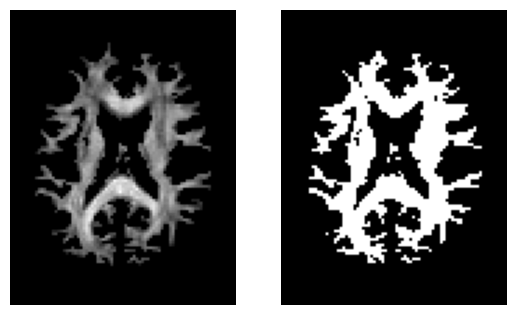

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

## 2.4. Specify where to begin the fibers tracking

There are different ways to place seeds, ie starting points from which the fiber tracking is started. This depends on the pathways you might like to model! For example, if you only wanted to model the corpus callosum it would not be so interesting to place seeds in other regions of the brain. <br>
So that you understand what the output of the cell below will be, we must first explain what you'll extract in the cell below.<br>
The orientation of an image is described by its affine transformation, if you remember well. Let's call this affine $A$.
A seed point at the center of voxel $[i,j,k]$ will be represented as $[x,y,z, 1]= A \cdot [i,j,k,1]$<br>
In other words, you will get **coordinates in voxel space**. Note that there is one important assumption: the voxels here should be isotropic (the size of a voxel should be same along all directions).

In our specific case, we will start from a sagittal slice of the **corpus callosum**, the one with label 2 to be specific.
Please, create the mask (based on the labels above) to extract **only the slice of corpus callosum with label 2 as a mask**. You can refer to what we did above to do so. 

In [81]:
from dipy.tracking import utils

seed_mask = labels == 2 # Your code here to extract only the place of interest! 
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

## 2.5. Bringing it all together and generating the streamlines
Let's see our ingredients:
- Seeds, generated above and starting from a slice of the corpus callosum
- A mask of regions where we should stop our fibers, based on anisotropy
- Peaks of ODF, at most five peaks per voxel

It remains now to combine all of these to bake so called streamlines (ie: fibers!). To do so, we will use the EuDX algorithm.

In [82]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines_t = Streamlines(streamlines_generator)

In [83]:
streamlines_t

ArraySequence([array([[ -4.5, -44.5,   7.5]]), array([[ -4.5, -44.5,   7.5]]), array([[ -4.5, -44.5,   7.5]]), ..., array([[-0.5, 32.5, 12.5]]), array([[ 0.5, 32.5, 12.5]]), array([[ 0.5, 32.5, 12.5]])])

Beautiful! Let's now visualize our streamlines!
Remember that they represent **only lines that start from the corpus callosum**! 

In [85]:
from dipy.viz import colormap

# Prepare the display objects.
color = colormap.line_colors(streamlines_t)

streamlines_actor = actor.line(streamlines_t,
                               colors=colormap.line_colors(streamlines_t))

# Create the 3D display.
scene = window.Scene()
scene.add(streamlines_actor)

showm = window.ShowManager(scene, size=(900,900), reset_camera=False)
showm.initialize()
ViewInteractiveWidget(scene.GetRenderWindow())

# Save still images for this static example. Or for interactivity use
#window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
#if interactive:
#    window.show(scene)

ViewInteractiveWidget(height=900, layout=Layout(height='auto', width='100%'), width=900)

## 2.6. Store the streamlines into a trackvis file

What if we wanted to save the result as a file? Well, you can! For this, we need to save it to a special format, the TrackVis (.trk) format.

Remember: our goal was to generate the streamlines. It is these streamlines that we therefore want to save! :) 
Let's do it! 

In [86]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram, save_trk

# This is for the cc slice tractogram
sft = StatefulTractogram(streamlines_t, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_EuDX.trk", streamlines_t)


If you want to visualize it all, you can activate <a href="https://trackvis.org/">TrackVis</a> and open the file from within! 

Fortunately, it is already installed in this environment. On the left tabs in Neurodesk, click on the last tab, "Softwares". Search trackvis and click load. You can then open a terminal within neurodesk and launc Trackvis to start having fun.

## 2.7 Conclusions

Let's sum up what we've seen. For a successfull tractography generation, we need the following: 
<table>
    <tr>
        <th>Ingredient</th>
        <th>Role</th>
        <th>How is it created?</th>
    </tr>
    <tr>
        <td>Seeds</td>
        <td>Define starting point of tract propagation.</td>
        <td>Can be done randomly or according to some mask of interest</td>
    </tr>
    <tr>
        <td>Diffusion directions</td>
        <td>Define the local diffusion in a voxel, for all voxels of interest</td>
        <td>Can be done with CSA-ODF or other methods such as e.g structure tensor</td>
    </tr>
    <tr>
        <td>Stopping criteria</td>
        <td>Defines where the tract continues or stops.</td>
        <td>Can be done based on anatomy, information of diffusion direction, combination of both...</td>
    </tr>
    <tr>
        <td>A tracking algorithm</td>
        <td>Combines all ingredients above to generate streamlines</td>
        <td>Line propagation techniques to grow from seed region, or probabilistic with a pdf of fiber orientations.</td>
    </tr>
</table> 


Each of the ingredients can be changed for a different flavour. You can explore <a href="https://docs.dipy.org/stable/examples_built/index">DIPY's tutorials</a> to get an idea of the changes you can operate. Feel free to play around!

## 2.8 Remark: Connectivity analysis based on tractography 

By using the generated streamlines, we could analyze the brain connectivity, for example, which streamlines pass through or not pass through some regions of the brain, how many streamlines are connecting two ROI, etc. To do this, it would be better if we could create a tractography with seeds spaning the entire white matter. Due to RAM concern, we will not do it here. But please feel free to explore it if you are interested! You will find some useful tutorials here:
<a href="https://docs.dipy.org/stable/examples_built/index#streamlines-analysis-and-connectivity">https://docs.dipy.org/stable/examples_built/index#streamlines-analysis-and-connectivity</a>

This ends this short tractography tutorial! Again, do not hesitate to explore more on DIPY's website if you're interested :)
We strongly encourage you to use TrackVis for visualization of tractograms as it's really made for it and is much more intuitive to use for this purpose than FSLeyes.

   


<div class="alert alert-success">
<p><b>🎉 You've reached the end of this week's notebook! Congratulations! 🎉 </b></p>
</div>